# Calculating functional and taxonomic diversity of transporters

## Overview

Here we will use the [Shannon diversity index](https://en.wikipedia.org/wiki/Diversity_index) to calculate both taxonomic diversity of transporters and functional diversity of most abundant taxa in each sample.

In [69]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.patches as mpatches
from scipy.stats import spearmanr, wilcoxon
import numpy as np
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')


## Functionality

In [70]:
def filter_low_abundance(df, f=0.5):
    # Calculate mean abundance of transporters
    df_trans_mean = df.groupby(["fam","transporter"]).sum().reset_index().groupby(["transporter"]).mean()
    # Normalize to percent
    n = df_trans_mean.div(df_trans_mean.sum())*100
    # Filter to those with max % >= to the threshold
    n = n.loc[n.max(axis=1)>=f]
    return set(n.index)


In [71]:
def shannon_proportions(counts,base=2):
    '''Modified version of shannon to handle proportions instead of absolute counts.'''
    # Generate list of floats
    counts = [float(item) for item in counts]
    counts = np.asarray(counts)
    if counts.sum()==0: return -1,0
    # frequencies are 
    freqs = counts / counts.sum()
    nonzero_freqs = freqs[freqs.nonzero()]
    return -(nonzero_freqs * np.log(nonzero_freqs)).sum() / np.log(base),len(nonzero_freqs)


In [72]:
def transporter_taxonomic_diversity(df,ranks,transporters,data_type,taxa):
    data = pd.DataFrame(columns=["rank","sample","transporter","dataset","taxa","diversity","num_taxa"])
    index = -1
    for rank in ranks:
        # Sum to abundance per family for each rank
        tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
        # Get mean transporter abundance for each rank
        tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
        samples = tmp_mean.columns[2:]
        for transporter in transporters:
            # Get transporter data
            tmp_trans = tmp_mean.loc[tmp_mean.transporter==transporter] 
            # Sum for the current rank and transporter
            tmp_trans_rank = tmp_trans.groupby(rank).sum() 
            # Normalize to % in each sample
            tmp_trans_rank_norm = tmp_trans_rank.div(tmp_trans_rank.sum())*100
            # Fill gaps
            tmp_trans_rank_norm.fillna(0,inplace=True)
            # For each sample, calculate diversity and number of taxa for this transporter
            for sample in samples:
                div,num_taxa = shannon_proportions(tmp_trans_rank_norm[sample])
                index+=1
                df_tmp = pd.DataFrame(index=[index],data={"rank":rank,"taxa":taxa,"dataset":data_type,"sample":sample,"transporter":transporter,"diversity":div,"num_taxa":num_taxa})
                data = pd.concat([data,df_tmp])
    return data

In [73]:
def taxonomic_functional_diversity(df,rank,data_type,t_quantile=0.9):
    # Create empty dataframe
    data = pd.DataFrame(columns=["taxa","sample","type","diversity","num_transporters"])
    # Sum to abundance per family for each rank
    tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
    # Get mean transporter abundance for each rank
    tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
    # Get total transporter abundance for each rank (sum over all transporters)
    # Also remove unclassified orders and environmental samples
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("unclassified", case=False)]
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("environmental samples", case=False)]
    tmp_trans_tax_sum = tmp_mean.groupby(rank).sum()    
    samples = tmp_mean.columns[2:]
    index=-1
    for sample in samples:
        # Calculate taxa that make up the quantiles for the transporter data
        q_trans_taxa = list(tmp_trans_tax_sum.loc[tmp_trans_tax_sum[sample]>tmp_trans_tax_sum[sample].quantile(q=t_quantile)].index)
        sample_taxa = q_trans_taxa
        for tax in sample_taxa:
            # Get tax data
            tmp_tax_trans = tmp_mean.loc[tmp_mean[rank]==tax,sample] 
            # Normalize
            tmp_tax_trans_norm = tmp_tax_trans.div(tmp_tax_trans.sum())*100
            # Calculate diversity and number of transporters for this order in this sample
            div,num_transporters = shannon_proportions(tmp_tax_trans_norm)
            index+=1
            # Add to dataframe
            df_tmp = pd.DataFrame(index=[index],data={"taxa":tax,"type":data_type,"sample":sample,"diversity":div,"num_transporters":num_transporters})
            data = pd.concat([data,df_tmp])
    taxsort = list(tmp_trans_tax_sum.loc[list(set(data.taxa))].mean(axis=1).sort_values(ascending=False).index)
    return data,taxsort

## Read sample groups

In [74]:
mg_groups = pd.read_csv("results/mg/samplegroups.tab", index_col=0, sep="\t")
mg_groups.rename(index=lambda x: str(x), inplace=True)


In [75]:
mt_groups = pd.read_csv("results/mt/samplegroups.tab", index_col=0, sep="\t")
mt_groups.rename(index=lambda x: str(x), inplace=True)


## Read transporter/taxonomic data

In [76]:
mg_taxcov = pd.read_table("results/mg/select_trans_genes.tpm.tsv", index_col=0)
mt_taxcov = pd.read_table("results/mt/select_trans_genes.tpm.tsv", index_col=0)

mg_all_taxcov = pd.read_table("results/mg/all_transporters.tpm.taxonomy.tsv.gz", index_col=0)
mt_all_taxcov = pd.read_table("results/mt/all_transporters.tpm.taxonomy.tsv.gz", index_col=0)

mg_all_taxraw = pd.read_table("results/mg/all_transporters.raw_counts.taxonomy.tsv.gz", index_col=0)
mt_all_taxraw = pd.read_table("results/mt/all_transporters.raw_counts.taxonomy.tsv.gz", index_col=0)


Filter low abundant transporters.

In [77]:
f = 0.5
mg_filtered = filter_low_abundance(mg_all_taxcov, f=f)
mt_filtered = filter_low_abundance(mt_all_taxcov, f=f)
all_filtered = list(mg_filtered.union(mt_filtered))
print("{} and {} ({} total) transporters with max % >= {} in the metagenomes and metatranscriptomes, respectively.".format(len(mg_filtered), len(mt_filtered), len(all_filtered), f))

81 and 84 (99 total) transporters with max % >= 0.5 in the metagenomes and metatranscriptomes, respectively.


In [78]:
mg_all_taxcov = mg_all_taxcov.loc[mg_all_taxcov.transporter.isin(all_filtered)]
mt_all_taxcov = mt_all_taxcov.loc[mt_all_taxcov.transporter.isin(all_filtered)]


In [79]:
mg_filtered_taxraw = mg_all_taxraw.loc[mg_all_taxraw.transporter.isin(all_filtered)]
mt_filtered_taxraw = mt_all_taxraw.loc[mt_all_taxraw.transporter.isin(all_filtered)]


Filter out orders to those that have at least 500 reads mapped on average across the datasets.

In [80]:
mg_filtered_taxraw_ordermean = mg_filtered_taxraw.groupby("order").sum().mean(axis=1)
mg_filtered_orders = mg_filtered_taxraw_ordermean.loc[(mg_filtered_taxraw_ordermean>=500)&(~mg_filtered_taxraw_ordermean.index.str.match("Unclassified"))].sort_values(ascending=False).index
print("\n".join(["{}: {} average reads".format(x,np.round(mg_filtered_taxraw_ordermean.loc[x],0)) for x in mg_filtered_orders]))

Flavobacteriales: 5413.0 average reads
Sphingobacteriales: 2626.0 average reads
Pelagibacterales: 1584.0 average reads
Cellvibrionales: 1530.0 average reads
Rhodobacterales: 998.0 average reads
Burkholderiales: 600.0 average reads
Opitutales: 592.0 average reads
Mamiellales: 546.0 average reads


In [81]:
mt_filtered_taxraw_ordermean = mt_filtered_taxraw.groupby("order").sum().mean(axis=1)
mt_filtered_orders = mt_filtered_taxraw_ordermean.loc[(mt_filtered_taxraw_ordermean>=500)&(~mt_filtered_taxraw_ordermean.index.str.match("Unclassified"))].sort_values(ascending=False).index
list(mt_filtered_orders)
print("\n".join(["{}: {} average reads".format(x,np.round(mt_filtered_taxraw_ordermean.loc[x],0)) for x in mt_filtered_orders]))

Flavobacteriales: 5976.0 average reads
Mamiellales: 1366.0 average reads
Cellvibrionales: 776.0 average reads
Sphingobacteriales: 613.0 average reads


Read information on transporters.

In [14]:
transinfo = pd.read_csv("selected_transporters_classified.tab", index_col=0, header=0, sep="\t")

In [83]:
categories = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]

In [84]:
genera = mg_all_taxcov.loc[(mg_all_taxcov.transporter.isin(transinfo.index))&(mg_all_taxcov["order"].isin(mg_filtered_orders)),"genus"].unique()
len([x for x in genera if not "Unclassified" in x])

13

Calculate functional diversity per sample for taxa at rank order. **For each sample, only consider taxa that are part of the upper 90% quantile.** This will hopefully make the functional diversity estimates more reliable.

In [17]:
mg_tax_fun_div,mg_taxsort = taxonomic_functional_diversity(mg_taxcov,rank="order",t_quantile=0.9,data_type="mg")


In [18]:
coldict = dict(zip(set(mg_filtered_orders).union(mt_filtered_orders),sns.color_palette("Set2", n_colors=len(set(mg_filtered_orders).union(mt_filtered_orders)))))

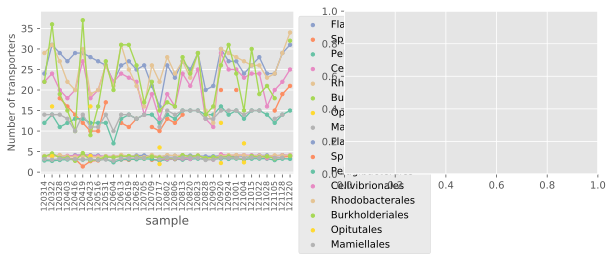

In [19]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,3))
ax1 = sns.pointplot(data=mg_tax_fun_div.loc[mg_tax_fun_div.taxa.isin(mg_filtered_orders)],y="diversity",x="sample",hue="taxa",
                   scale=0.5, ax=axes[0],palette=coldict, hue_order=mg_filtered_orders)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=8);
ax1.legend_.remove()
ax1.set_ylabel("Transporter diversity", fontsize=10)

ax2 = sns.pointplot(data=mg_tax_fun_div.loc[mg_tax_fun_div.taxa.isin(mg_filtered_orders)],y="num_transporters",x="sample",hue="taxa",
                  scale=0.5, ax=axes[0],palette=coldict, hue_order=mg_filtered_orders)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90, fontsize=8);
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_ylabel("Number of transporters", fontsize=10)

plt.savefig("NEW_figures_2020/Figure_4.eps", bbox_inches="tight")

In [20]:
mt_tax_fun_div,mt_taxsort = taxonomic_functional_diversity(mt_taxcov,rank="order",t_quantile=0.9,data_type="mt")

Text(0, 0.5, 'Number of transporters')

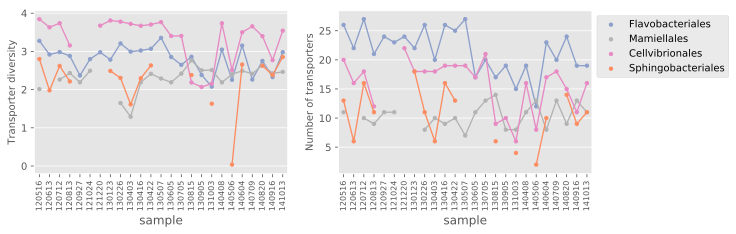

In [21]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,3))
ax1 = sns.pointplot(data=mt_tax_fun_div.loc[mt_tax_fun_div.taxa.isin(mt_filtered_orders)],y="diversity",x="sample",hue="taxa",
                    scale=0.5, ax=axes[0],palette=coldict, hue_order=mt_filtered_orders)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=8);
ax1.legend_.remove()
ax1.set_ylabel("Transporter diversity", fontsize=10)

ax2 = sns.pointplot(data=mt_tax_fun_div.loc[mt_tax_fun_div.taxa.isin(mt_filtered_orders)],y="num_transporters",x="sample",hue="taxa",
                    scale=0.5, ax=axes[1],palette=coldict, hue_order=mt_filtered_orders)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90, fontsize=8);
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_ylabel("Number of transporters", fontsize=10)